前面已经学习了基础知识的学习和几种数据分析师最常用文件的读写和处理。因此《Python数据分析基础》讲完这些就用一章的篇幅讲了几个基于现实需求的项目，每个项目代码量都挺大的。我们就进入书的**第五章 小型应用**的学习，如果在理解下面的代码过程中遇到了问题可以和我讨论或试着在之前的笔记中找到答案或者网上搜索问题。


### 目录

- 在一个文件夹中的多个文件中搜索特定内容
- 为CSV文件中数据的任意数目分类计算统计量
- 为文本文件中数据的任意数目分类计算统计量
- csv文件转换为字典

## 在一个文件夹中的多个文件中搜索特定内容
这一章的第一个应用需求是**在有大量历史数据的时候，要找到真正需要的数据**。

具体例子：
在有 300 个 Excel 工作簿和 200 个 CSV 文件的文件夹里找到需要的数据。输入：一个存着数据表达形式相同的多个文件的文件夹；要找的数据列表；输出文件名。


In [2]:
import re
import csv
import glob
import sys
from datetime import date
from xlrd import open_workbook, xldate_as_tuple
def searchItemFromFolder(path_to_folder,item_numbers_to_find,output_file):
    filewriter = csv.writer(open(output_file, 'a', newline=''))
    file_counter = 0
    line_counter = 0
    count_of_item_numbers = 0
    for input_file in glob.glob(os.path.join(path_to_folder, '*.*')):
        file_counter += 1
        f_type=fileType(input_file)
        if f_type== 'csv': #可以re库判断是否为csv文件
            with open(input_file, 'r', newline='') as csv_in_file:
                filereader = csv.reader(csv_in_file)
                header = next(filereader)
                for row in filereader:
                    row_of_output = []
                    for column in range(len(header)):
                        if column < 3:
                            cell_value = str(row[column]).strip()
                            row_of_output.append(cell_value)
                        elif column == 3:
                            cell_value = str(row[column]).lstrip('$').replace(',','').split('.')[0].strip()
                            row_of_output.append(cell_value)
                        else:
                            cell_value = str(row[column]).strip()
                            row_of_output.append(cell_value)
                    row_of_output.append(os.path.basename(input_file))
                    if row[0] in item_numbers_to_find:
                        filewriter.writerow(row_of_output)
                        count_of_item_numbers += 1
                    line_counter += 1
        elif f_type== 'Excel':
            workbook = open_workbook(input_file) #Excel的打开
            for worksheet in workbook.sheets():
                try:
                    header = worksheet.row_values(0)
                except IndexError:
                    pass
                for row in range(1, worksheet.nrows):
                    row_of_output = []
                    for column in range(len(header)):
                        if column < 3:
                            cell_value = str(worksheet.cell_value(row,column)).strip()
                            row_of_output.append(cell_value)
                        elif column == 3:
                            cell_value = str(worksheet.cell_value(row,column)).split('.')[0].strip()
                            row_of_output.append(cell_value)
                        else:
                            cell_value = xldate_as_tuple(worksheet.cell(row,column).value,workbook.datemode)
                            cell_value = str(date(*cell_value[0:3])).strip()
                            row_of_output.append(cell_value)
                    row_of_output.append(os.path.basename(input_file))
                    row_of_output.append(worksheet.name) #把表名装入数组
                    if str(worksheet.cell(row,0).value).split('.')[0].strip() in item_numbers_to_find:
                        filewriter.writerow(row_of_output)
                        count_of_item_numbers += 1
                    line_counter += 1
    print('Number of files: {}'.format(file_counter))
    print('Number of lines: {}'.format(line_counter))
    print('Number of item numbers: {}'.format(count_of_item_numbers))
    
def fileType(in_file):  #判断文件类型
    pcsv=re.compile(r'\.csv$')
    pv=pcsv.search(in_file)
    if pv!=None: #csv文件
        return 'csv'
    else:
        pxls=re.compile(r'\.(xls)|(xlsx)$')
        px=pxls.search(in_file)
        if px!=None:
            return 'Excel'
        else:
            return 'fileTypeNotSupport'

#调用：
#searchItemFromFolder(path_to_folder,item_numbers_to_find，output_file)

我们之前没有涉及到过这么长的代码，但整体思路不难理解，很多片段是我们之前的笔记写过的。


### 为CSV文件中数据的任意数目分类计算统计量
应用场景：

> 在很多商业分析中，需要**为一个特定时间段内的未知数目的分类计算统计量**。举例来说，假设我们销售 5 种不同种类的产品，你想计算一下在某一年中对于所有客户的按产品种类分类的总销售额。因为客户具有不同的品味和偏好，他们在一年中购买的产品也是不同的。有些客户购买了所有 5 种产品，有些客户则只购买了一种产品。在这种客户购买习惯之下，与每个客户相关的产品分类数目都是不同的。


In [3]:
import csv
import sys
from datetime import date, datetime

#计算输入csv文件的统计量
def calcStatistic(input_file,output_file):
    #输入参数：输入的csv文件，输出结果文件
    packages = {}
    previous_name = 'N/A'
    previous_package = 'N/A'
    previous_package_date = 'N/A'
    first_row = True #是否在处理输入文件中的第一行数据
    today = date.today().strftime('%m/%d/%Y')

    with open(input_file, 'r', newline='') as input_csv_file:
        filereader = csv.reader(input_csv_file)
        header = next(filereader)
        for row in filereader:
            current_name = row[0]
            current_package = row[1]
            current_package_date = row[3]
            if current_name not in packages:
                packages[current_name] = {}
            if current_package not in packages[current_name]:
                packages[current_name][current_package] = 0
            if current_name != previous_name:
                if first_row:
                    first_row = False
                else:
                    diff = date_diff(today, previous_package_date)
                    if previous_package not in packages[previous_name]:
                        packages[previous_name][previous_package] = int(diff)
                    else:
                        packages[previous_name][previous_package] += int(diff)
            else:
                diff = date_diff(current_package_date, previous_package_date)
                packages[previous_name][previous_package] += int(diff)
            previous_name = current_name
            previous_package = current_package
            previous_package_date = current_package_date

    header = ['Customer Name', 'Category', 'Total Time (in Days)']
    with open(output_file, 'w', newline='') as output_csv_file:
        filewriter = csv.writer(output_csv_file)
        filewriter.writerow(header)
    for customer_name, customer_name_value in packages.items():
        for package_category, package_category_value in packages[customer_name].items():
            row_of_output = []
            print(customer_name, package_category, package_category_value)
            row_of_output.append(customer_name)
            row_of_output.append(package_category)
            row_of_output.append(package_category_value)
            filewriter.writerow(row_of_output)

def date_diff(date1, date2): #时间戳处理函数
    #计算并返回两个日期之间间隔的天数
    try:
        diff = str(datetime.strptime(date1, '%m/%d/%Y') - datetime.strptime(date2, '%m/%d/%Y')).split()[0]
    except:
        diff = 0
    if diff == '0:00:00':
        diff = 0
    return diff

#calcStatistic(input_file,output_file)

### 从文本文件中提取数据并根据这些数据计算统计量
文本文件也是数据的重要保存媒介，文本文件和csv文件相比，有一定结构，但结构不是简单的行与列，所以处理起来相对复杂些。像日志这种文本文件经常保存着一些分散的数据，可以进行分析、聚集和解释，以产生一些新的知识。

具体的应用场景：

> MySQL错误日志文件记录着错误的类型和发生时间。在它的原始状态下，我们很难看出是否有某种错误发生的比其他错误更频繁，或者是否某种错误的频率会随着时间发生变化。通过解析这个文本文件，将相关信息聚集起来，然后以合适的形式写入一个输出文件，就可以从数据中获得知识，促使我们采取正确的行动。

![本文涉及的MySQL日志文件格式](./dsIpynbPic/mysql_error_log_pic.png)

对于这个应用，思路是：因为结构化不好，逐行读写，利用每行的标志区分是什么数据，通过空格切分数据。


Date,InnoDB: Compressed tables use zlib 1.2.3,InnoDB: Using atomics to ref count buffer pool pages,InnoDB: 5.6.16 started; log sequence number 1234567,/usr/local/mysql/bin/mysqld: Shutdown complete,InnoDB: Completed initialization of buffer pool,InnoDB: IPv6 is available.

2014-02-03,2,2,1,1,0,0

2014-03-07,3,1,1,1,0,0

2014-10-27,0,0,1,1,2,2



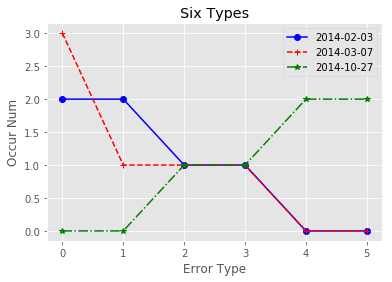

In [5]:
def parseTextFile(input_file,output_file):
    #因为是读写文本文件，不需要其他库，对结构性不好的txt用numpy、pandas等处理并明智
    messages = {}
    #镶套字典格式：{'错误发生日期':{'错误消息':'该日期错误发生次数'}}
    notes = []
    with open(input_file, 'r', newline='',encoding='UTF-8') as text_file:
        for row in text_file:
            if '[Note]' in row: #包含字符串 [Note] 的行就是包含错误消息的行
                row_list = row.split(' ', 4) #拆分每行
                day = row_list[0].strip()
                note = row_list[4].strip('\n').strip()
                if note not in notes:
                    notes.append(note)
                if day not in messages: 
                    messages[day] = {}
                if note not in messages[day]: #检验变量 note 中的错误消息是否还不是内部字典中的一个键
                    messages[day][note] = 1
                else:
                    messages[day][note] += 1

    filewriter = open(output_file, 'w', newline='')
    header = ['Date']
    header.extend(notes)
    header = ','.join(map(str,header)) + '\n'
    print(header)
    filewriter.write(header)
    n_lst=[]
    for day, day_value in messages.items():
        row_of_output = []
        row_of_output.append(day)
        for index in range(len(notes)):
            if notes[index] in day_value.keys():
                row_of_output.append(day_value[notes[index]])
            else:
                row_of_output.append(0)
        output = ','.join(map(str,row_of_output)) + '\n'
        n_lst.append(row_of_output)
        print(output)
        filewriter.write(output)
    filewriter.close()
    visualizeData(n_lst) #简单可视化
    
#简单可视化函数
def visualizeData(nlst): #限定为 3*n的二维列表
    import matplotlib.pyplot as plt
    %matplotlib inline  
    plt.style.use('ggplot')

    fig = plt.figure()
    ax1 = fig.add_subplot(1,1,1)
    ax1.plot(nlst[0][1:], marker=r'o', color=u'blue', linestyle='-',label=nlst[0][0])
    ax1.plot(nlst[1][1:], marker=r'+', color=u'red', linestyle='--', label=nlst[1][0])
    ax1.plot(nlst[2][1:], marker=r'*', color=u'green', linestyle='-.', label=nlst[2][0])
    ax1.xaxis.set_ticks_position('bottom')
    ax1.yaxis.set_ticks_position('left')

    ax1.set_title('Six Types')
    plt.xlabel('Error Type')
    plt.ylabel('Occur Num')
    plt.legend(loc='best')

    
in_f='./mysql_server_error_log.txt'
out_f='error_log_data_out.csv'
parseTextFile(in_f,out_f) #调用

原书第5章到这里就结束了，但是练习题有个题目挺有趣的，也是比较有用的，上面处理MySQL错误日志时，进行了镶套字典到csv行列数据的转换，这个练习的输出的字典就是简化的json格式，json是前端用得非常广泛的数据，所以这里补充到这篇笔记里。题目描述：

> 练习使用字典来为数据分类。例如，将 Excel 工作表或 CSV 文件中的数据解析成一个字典，使输入文件中每一列都是字典中的一个键-值对。也就是说，每列标题是字典中的键，每个键对应的值就是相应列中的数据。

下面给了两种实现方式，各有优势。

In [7]:
#用csv库实现
def rowColToDict(fname):
    import csv
    with open(fname, 'r', newline='') as csv_file:
        filereader = csv.reader(csv_file, delimiter=',')
        at_key=True  #刚读到首行
        for r_lst in filereader:
            if at_key: #循环在表的标题时
                d_key=r_lst
                l_k=len(d_key)
                d_val=[[] for i in range(l_k)]
                at_key=False
            else:
                for i in range(l_k):
                    d_val[i].append(r_lst[i])
            print(r_lst)        
        d_out={d_key[i]:d_val[i] for i in range(l_k)}
        print('转换后的字典:\n',d_out)
        #return d_out

f='./supplier_data.csv'
rowColToDict(f)

['Supplier Name', 'Invoice Number', 'Part Number', 'Cost', 'Purchase Date']
['Supplier X', '001-1001', '2341', '$500.00', '1/20/14']
['Supplier X', '001-1001', '2341', '$500.00', '1/20/14']
['Supplier X', '001-1001', '5467', '$750.00', '1/20/14']
['Supplier X', '001-1001', '5467', '$750.00', '1/20/14']
['Supplier Y', '50-9501', '7009', '$250.00', '1/30/14']
['Supplier Y', '50-9501', '7009', '$250.00', '1/30/14']
['Supplier Y', '50-9505', '6650', '$125.00', '2/3/14']
['Supplier Y', '50-9505', '6650', '$125.00', '2/3/14']
['Supplier Z', '920-4803', '3321', '$615.00', '2/3/14']
['Supplier Z', '920-4804', '3321', '$615.00', '2/10/14']
['Supplier Z', '920-4805', '3321', '$615.00', '2/17/14']
['Supplier Z', '920-4806', '3321', '$615.00', '2/24/14']
转换后的字典:
 {'Supplier Name': ['Supplier X', 'Supplier X', 'Supplier X', 'Supplier X', 'Supplier Y', 'Supplier Y', 'Supplier Y', 'Supplier Y', 'Supplier Z', 'Supplier Z', 'Supplier Z', 'Supplier Z'], 'Invoice Number': ['001-1001', '001-1001', '001-10

In [9]:
#用pandas库实现
def rowColToDictpd(fname):
    import pandas as pd
    dataf=pd.read_csv(fname)
    print(dataf)
    d_key=list(dataf.columns)
    l_k=len(d_key)
    d_pd={} #d_pd=dict()
    for col in d_key:
        d_pd[col]=list(dataf.loc[:,col])
    print('转换后字典:\n',d_pd)
    #print(pd.DataFrame(d_pd)) #可以比较好地转换回dataframe格式，但是由于字典的无序，col排列顺序会变化
    
#这种方法因为pd读csv生成dataframe时，对于数字，会进行类型转换，所以获得的字典数据不都是字符串
f='./supplier_data.csv'
rowColToDictpd(f)

   Supplier Name Invoice Number  Part Number     Cost Purchase Date
0     Supplier X       001-1001         2341  $500.00       1/20/14
1     Supplier X       001-1001         2341  $500.00       1/20/14
2     Supplier X       001-1001         5467  $750.00       1/20/14
3     Supplier X       001-1001         5467  $750.00       1/20/14
4     Supplier Y        50-9501         7009  $250.00       1/30/14
5     Supplier Y        50-9501         7009  $250.00       1/30/14
6     Supplier Y        50-9505         6650  $125.00        2/3/14
7     Supplier Y        50-9505         6650  $125.00        2/3/14
8     Supplier Z       920-4803         3321  $615.00        2/3/14
9     Supplier Z       920-4804         3321  $615.00       2/10/14
10    Supplier Z       920-4805         3321  $615.00       2/17/14
11    Supplier Z       920-4806         3321  $615.00       2/24/14
转换后字典:
 {'Supplier Name': ['Supplier X', 'Supplier X', 'Supplier X', 'Supplier X', 'Supplier Y', 'Supplier Y', 'Supp

上面4个例子代码都挺长的，也很实用，一些相关的项目也可以根据这些代码进行更改和拓展，因此理解和实践这部分代码对Python技能的提高很有帮助。下一篇笔记会进入可视化的内容，用图表表现数据。